This notebooks shows how to use the adaptive sampler using a simple test function.

The first step is to do all the imports needed.

In [1]:
from gumps.apps.adaptive_sampler import AdaptiveSamplerApp, AdaptiveSamplerAppParameters
from gumps.solvers.adaptive_solver import AdaptiveSamplerParameters

from gumps.solvers.regressors.gaussian_regressor import GaussianRegressor
from gumps.solvers.regressors.regression_solver import RegressionParameters

from gumps.solvers.regressors.bayesian_regressor import BayesianRegressor, BayesianRegressionParameters

from gumps.solvers.sampler import SamplerSolverParameters
from gumps.apps.parametric_sweep import ParametricSweepApp

from gumps.graph.regressor import RegressorPlotParameters, RegressorPlot

from gumps.studies.batch_study import AbstractBatchStudy
from typing import Callable

import pandas as pd
import numpy as np

%matplotlib inline

First we need to gather some initial data. For this example the model will be the BatchLineStudy.

In [2]:
parameters = SamplerSolverParameters(
    number_of_samples = 20,
    lower_bound = {'a':0, 'b':0, 'c':0, 'd':0, 'e':0},
    upper_bound = {'a':1, 'b':1, 'c':1, 'd':1, 'e':1},
    sampler = "sobol"
    )

class SyntheticBatchStudy(AbstractBatchStudy):
    "batch version of sphere study (designed to approximate surrogate model)"

    def __init__(self, *, model_variables:dict):
        self.model_variables = model_variables

    def start(self):
        "initialize this study"

    def stop(self):
        "handle shutdown tasks"

    def run(self, input_data:pd.DataFrame, processing_function:Callable|None=None) -> pd.DataFrame:
        "run the batch simulation"
        output_data = pd.DataFrame()
        output_data["f"] = input_data["a"] + input_data["b"] + input_data["c"] + input_data["d"] + input_data["e"]
        output_data["g"] = input_data["a"] ** 3 + input_data["b"] ** 2 + input_data["c"] * input_data["d"] ** 2 + input_data["e"]
        output_data["h"] = input_data["a"] ** 2 + input_data["b"] ** 2 + input_data["c"] ** 2 + input_data["d"] ** 2 + input_data["e"] ** 2
        
        self.save_results(input_data, output_data)

        if processing_function is None:
            return output_data
        else:
            return processing_function(output_data)
        
batch = SyntheticBatchStudy(model_variables={})

Next we need to sample from this model to gather the data needed for regression.

First we need a function that returns the model output and adds a bit of noise to the data

In [3]:
def get_all_with_noise(frame:pd.DataFrame) -> pd.DataFrame:
    "processing function to get the total from the dataframe"
    return frame * np.random.normal(1, 0.05, frame.shape)

Then we need to run the sampling

In [4]:
app = ParametricSweepApp(parameters=parameters,
        processing_function=get_all_with_noise,
        directory=None,
        batch=batch)
app.run()

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Set the starting point for response plots

In [5]:
start = app.factors.mean()
lower_bound = app.factors.min()
upper_bound = app.factors.max()

Lets look at a simple bayesian polynomial regression model  (with only 20 points we can't go higher than a first order model)

In [6]:
bayes_regression_parameters = BayesianRegressionParameters(input_data=app.factors,
            output_data=app.responses, order=1)
bayes_regressor = BayesianRegressor(bayes_regression_parameters)
bayes_regressor.fit()

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/sklearn/linear_model/_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/sklearn/linear_model/_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/sklearn/linear_model/_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(


What does the regression look like? What is the quality of fit?

Score 0.9318


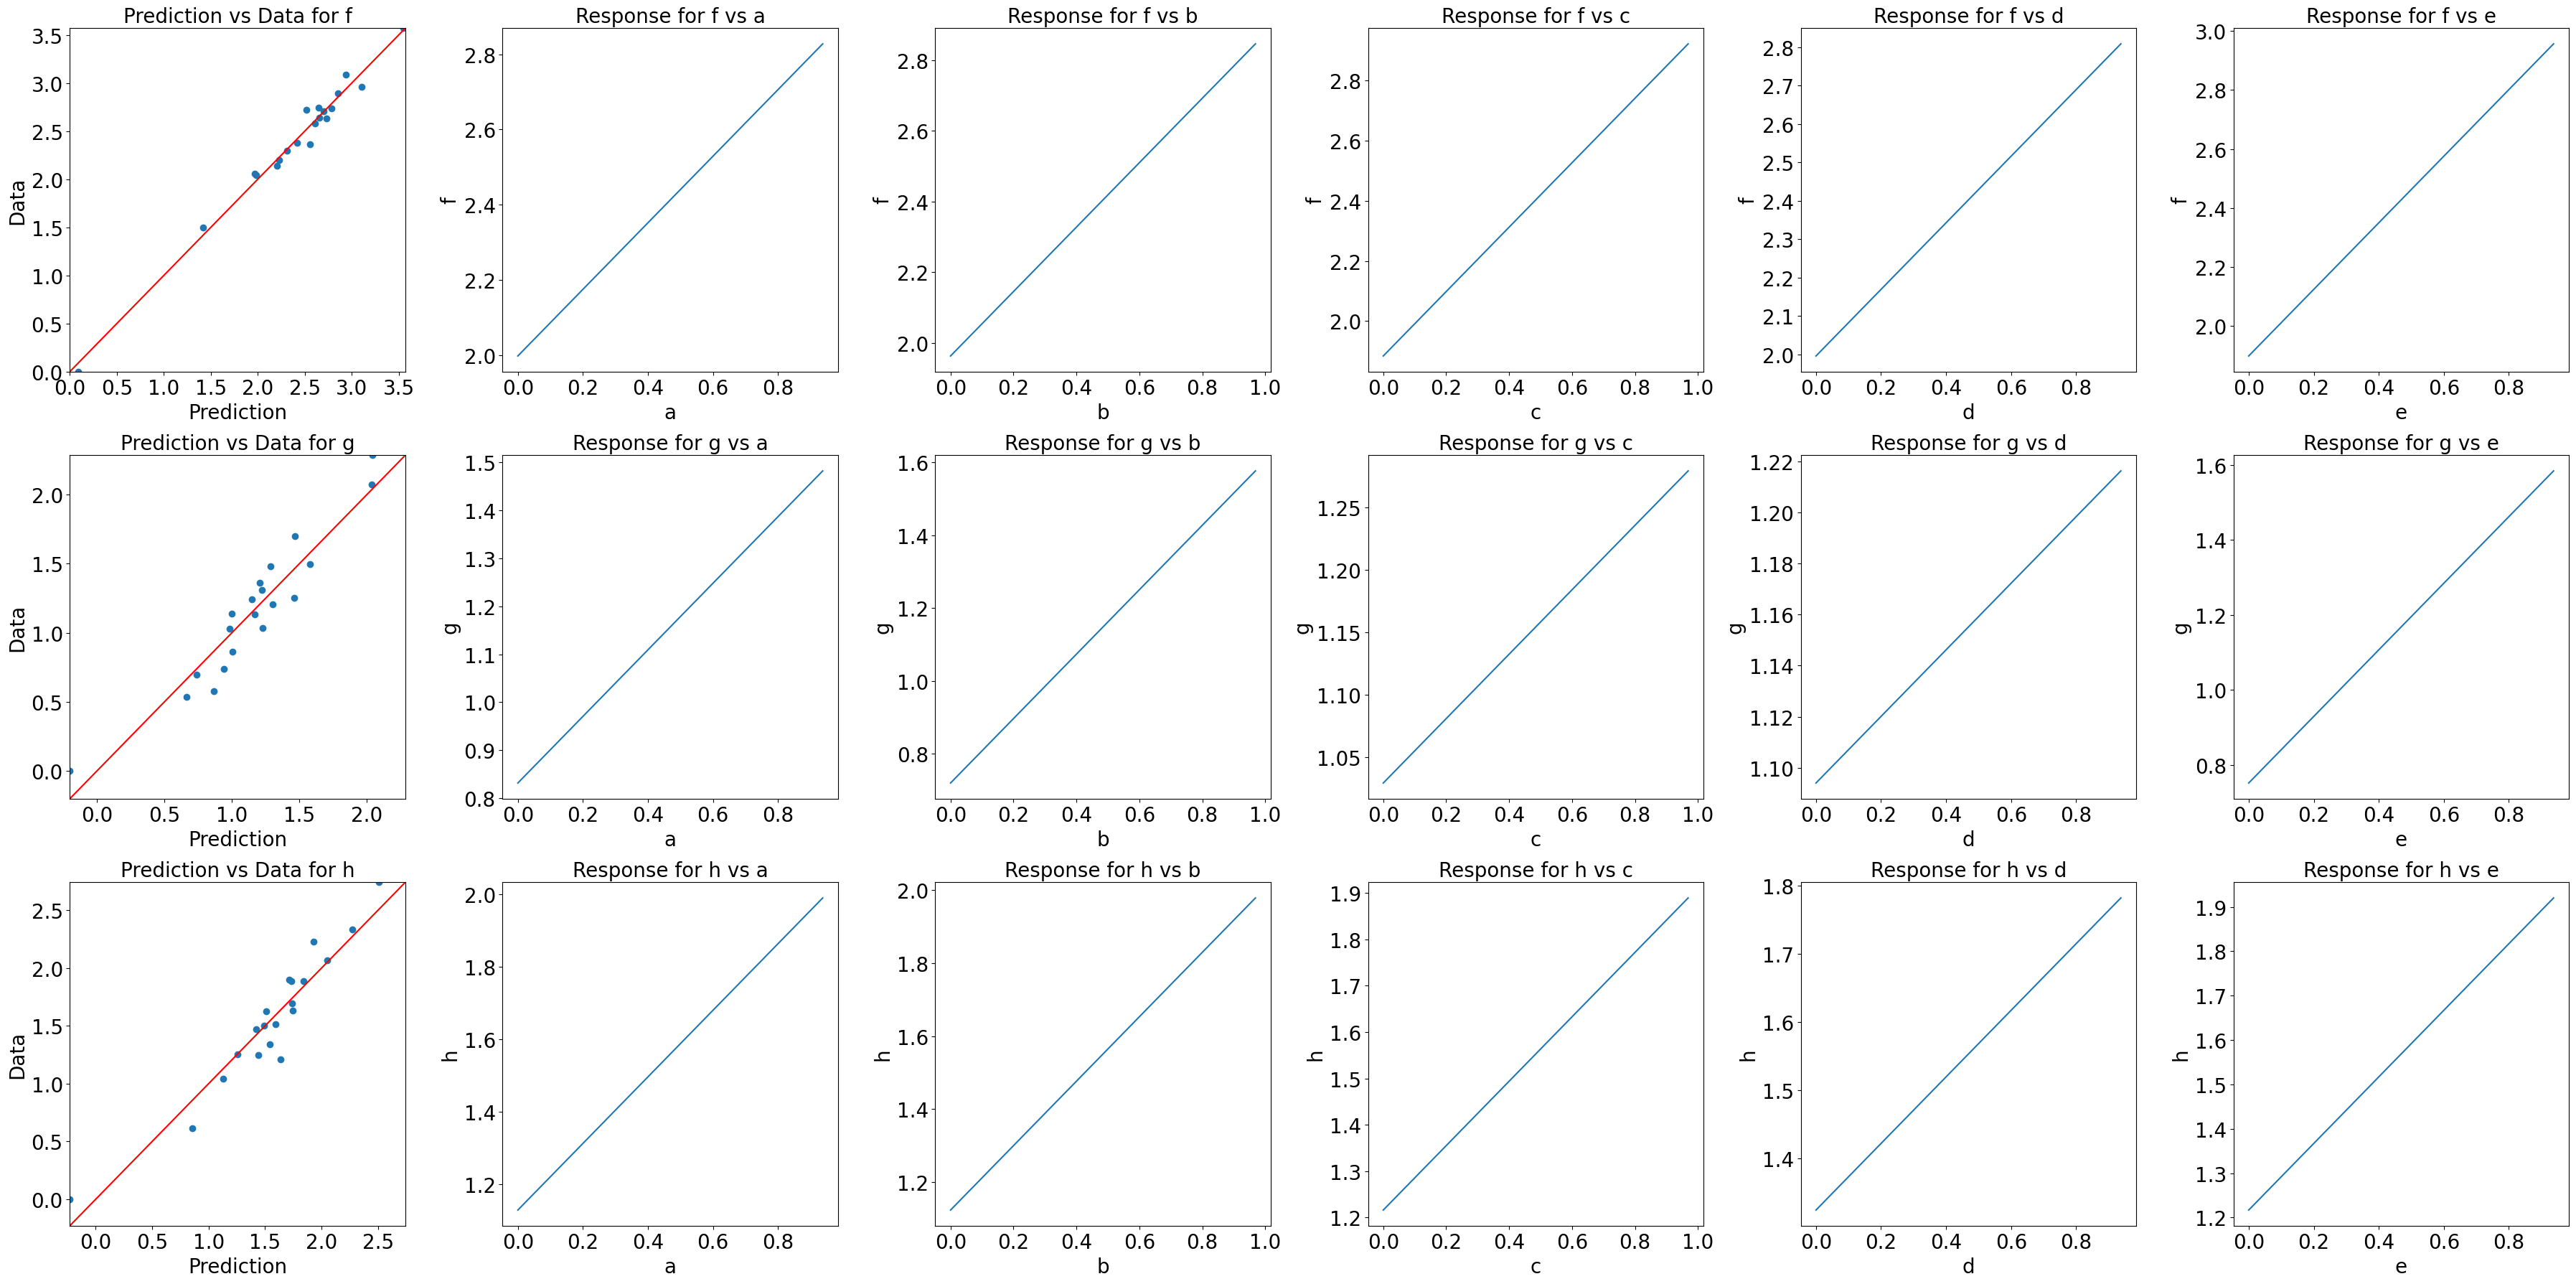

In [7]:
print(f"Score {bayes_regressor.error_metrics()['score']:.4f}")

params = RegressorPlotParameters(bayes_regressor, start, lower_bound, upper_bound)
params = RegressorPlotParameters(bayes_regressor, start, lower_bound, upper_bound)
reg_plot = RegressorPlot(params)
reg_plot.plot()

Build a Gaussian Process regression model to use with adaptive sampling

In [8]:
gpr_regression_parameters = RegressionParameters(input_data=app.factors,
            output_data=app.responses)
gpr_regressor = GaussianRegressor(gpr_regression_parameters)
gpr_regressor.fit()

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Visualize the regressor

Score 1.0000


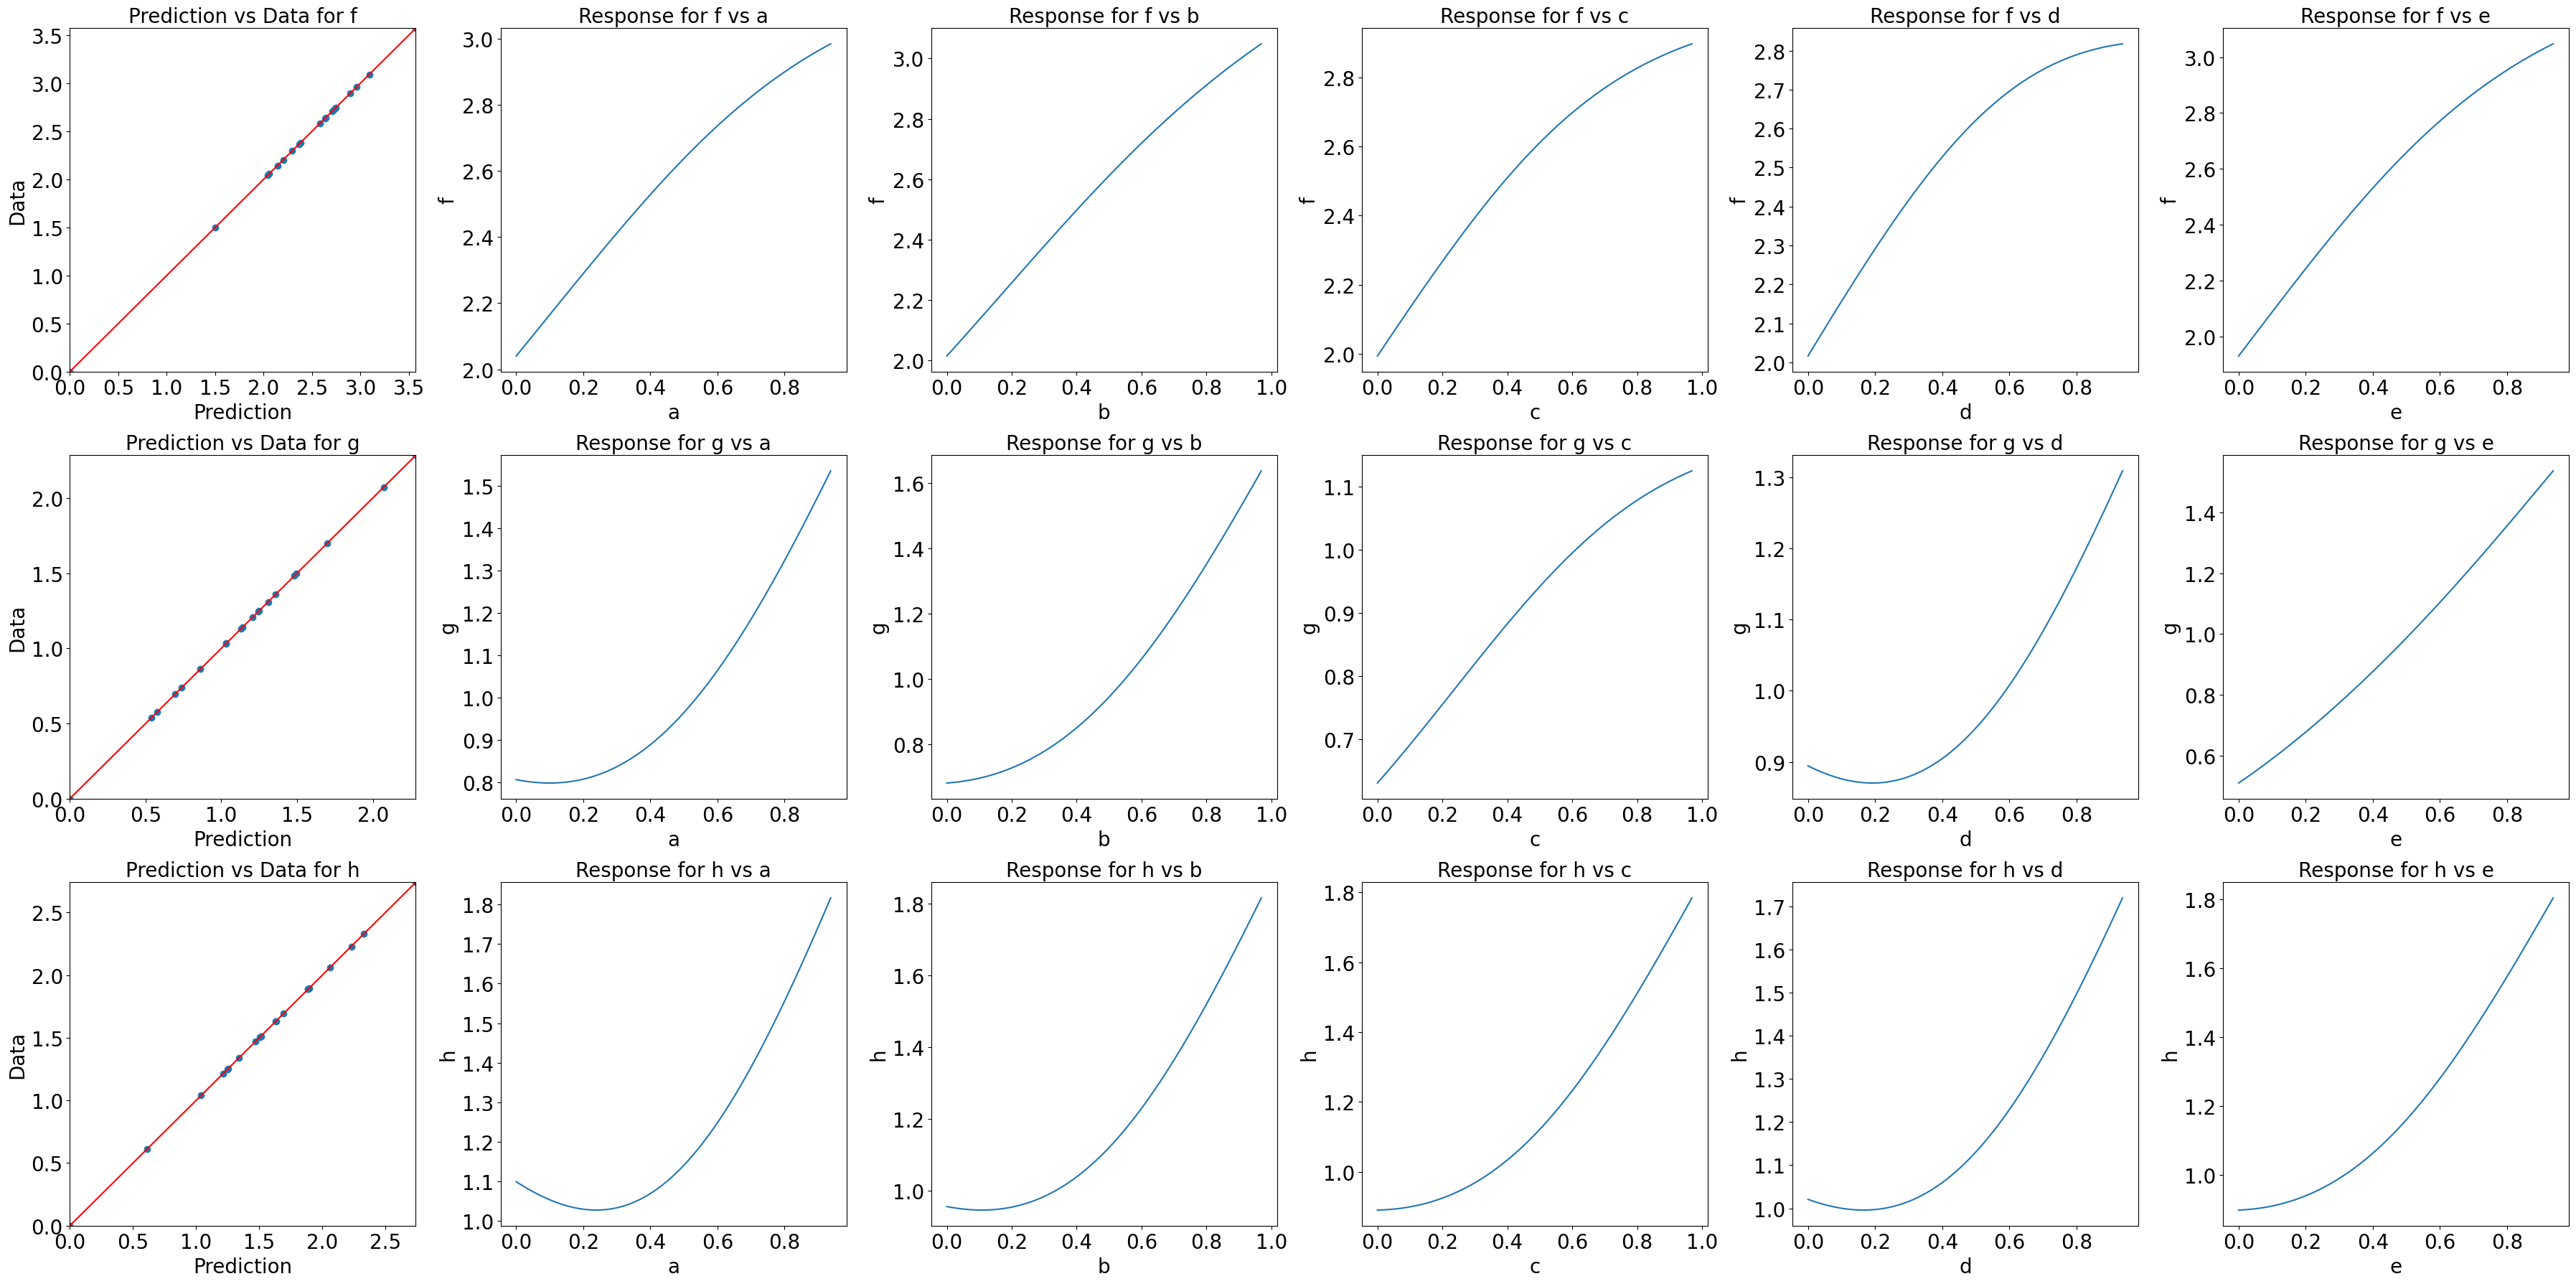

In [9]:
print(f"Score {gpr_regressor.error_metrics()['score']:.4f}")

params = RegressorPlotParameters(gpr_regressor, start, lower_bound, upper_bound)
reg_plot = RegressorPlot(params)
reg_plot.plot()

Lets use the adaptive sampler to additional points to the model

In [10]:
sampler_parameters = AdaptiveSamplerParameters(
    points_to_add=50,
    batch_size=10,
    max_iterations=100,
    population_size=100
)

parameters = AdaptiveSamplerAppParameters(
    regressor=gpr_regressor,
    sampler_parameters = sampler_parameters
    )

app = AdaptiveSamplerApp(parameters=parameters,
                            batch=batch,
                            processing_function=get_all_with_noise)
app.run()

Lets visualize the regressor again and see how this worked, we can clearly see that the point are spread out around the space.

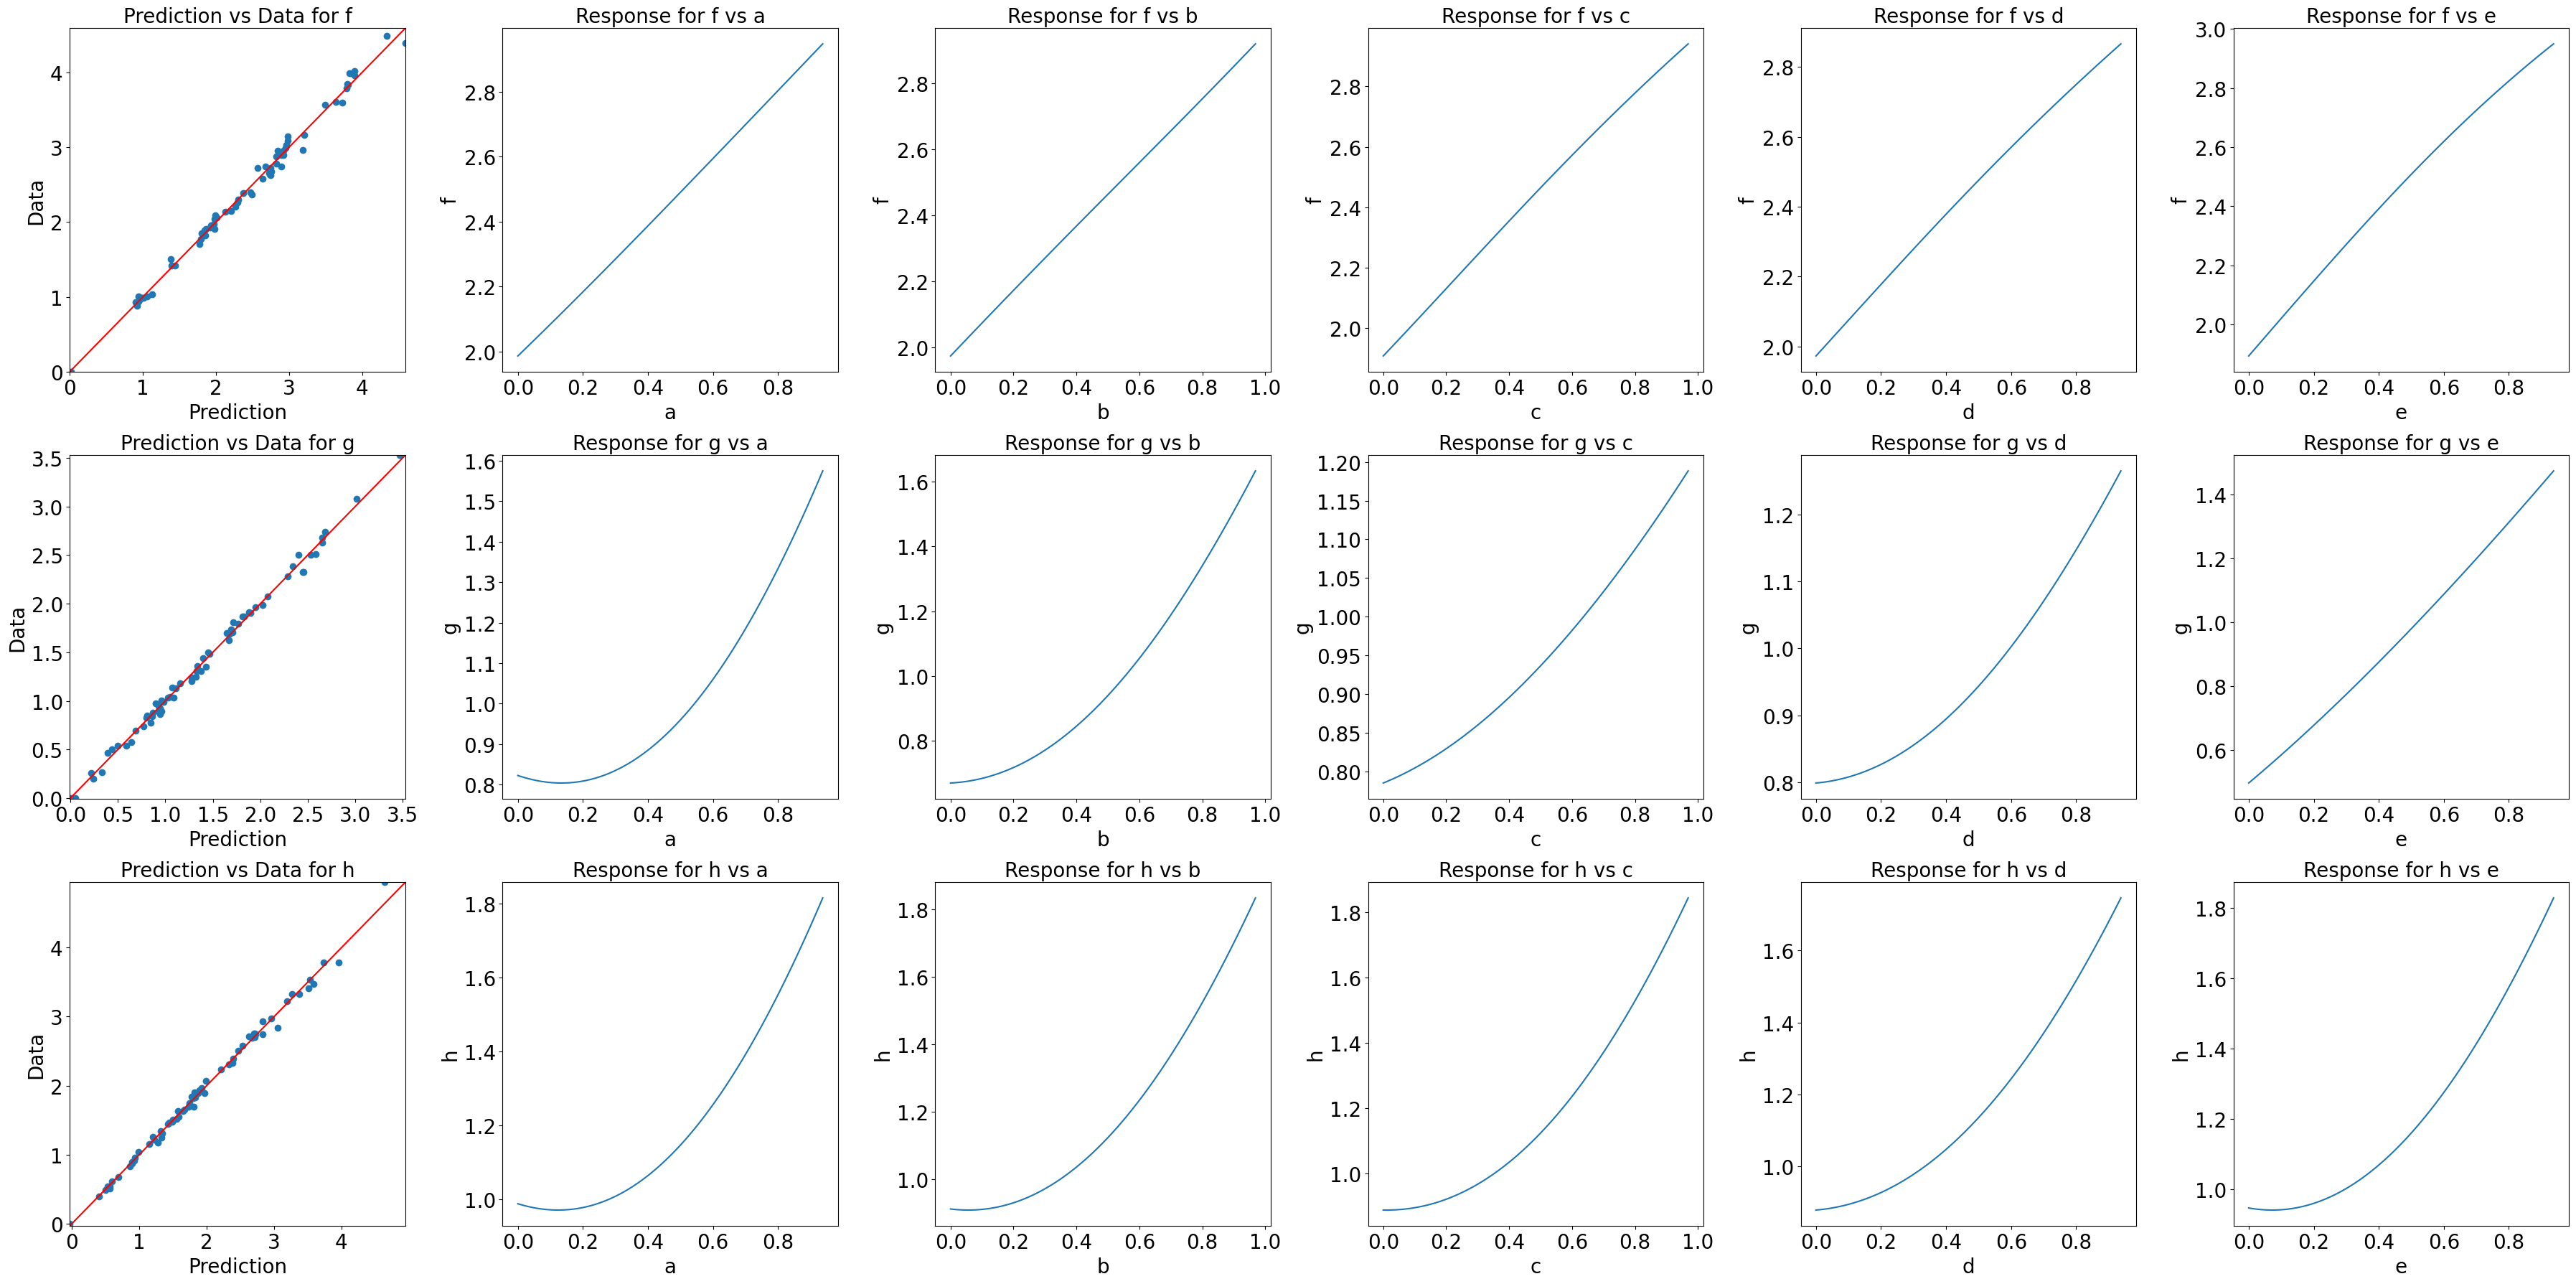

In [11]:
params = RegressorPlotParameters(gpr_regressor, start, lower_bound, upper_bound)

reg_plot = RegressorPlot(params)
reg_plot.plot()

Lets look at the error metrics.

In [12]:
print(f"Score {gpr_regressor.error_metrics()['score']:.4f}")

Score 0.9947


Lets sample even more points and see how the model improves

In [13]:
sampler_parameters = AdaptiveSamplerParameters(
    points_to_add=100,
    batch_size=1,
    max_iterations=100,
    population_size=100
)

parameters = AdaptiveSamplerAppParameters(
    regressor=gpr_regressor,
    sampler_parameters = sampler_parameters
    )

app = AdaptiveSamplerApp(parameters=parameters,
                            batch=batch,
                            processing_function=get_all_with_noise)
app.run()

And look at the results

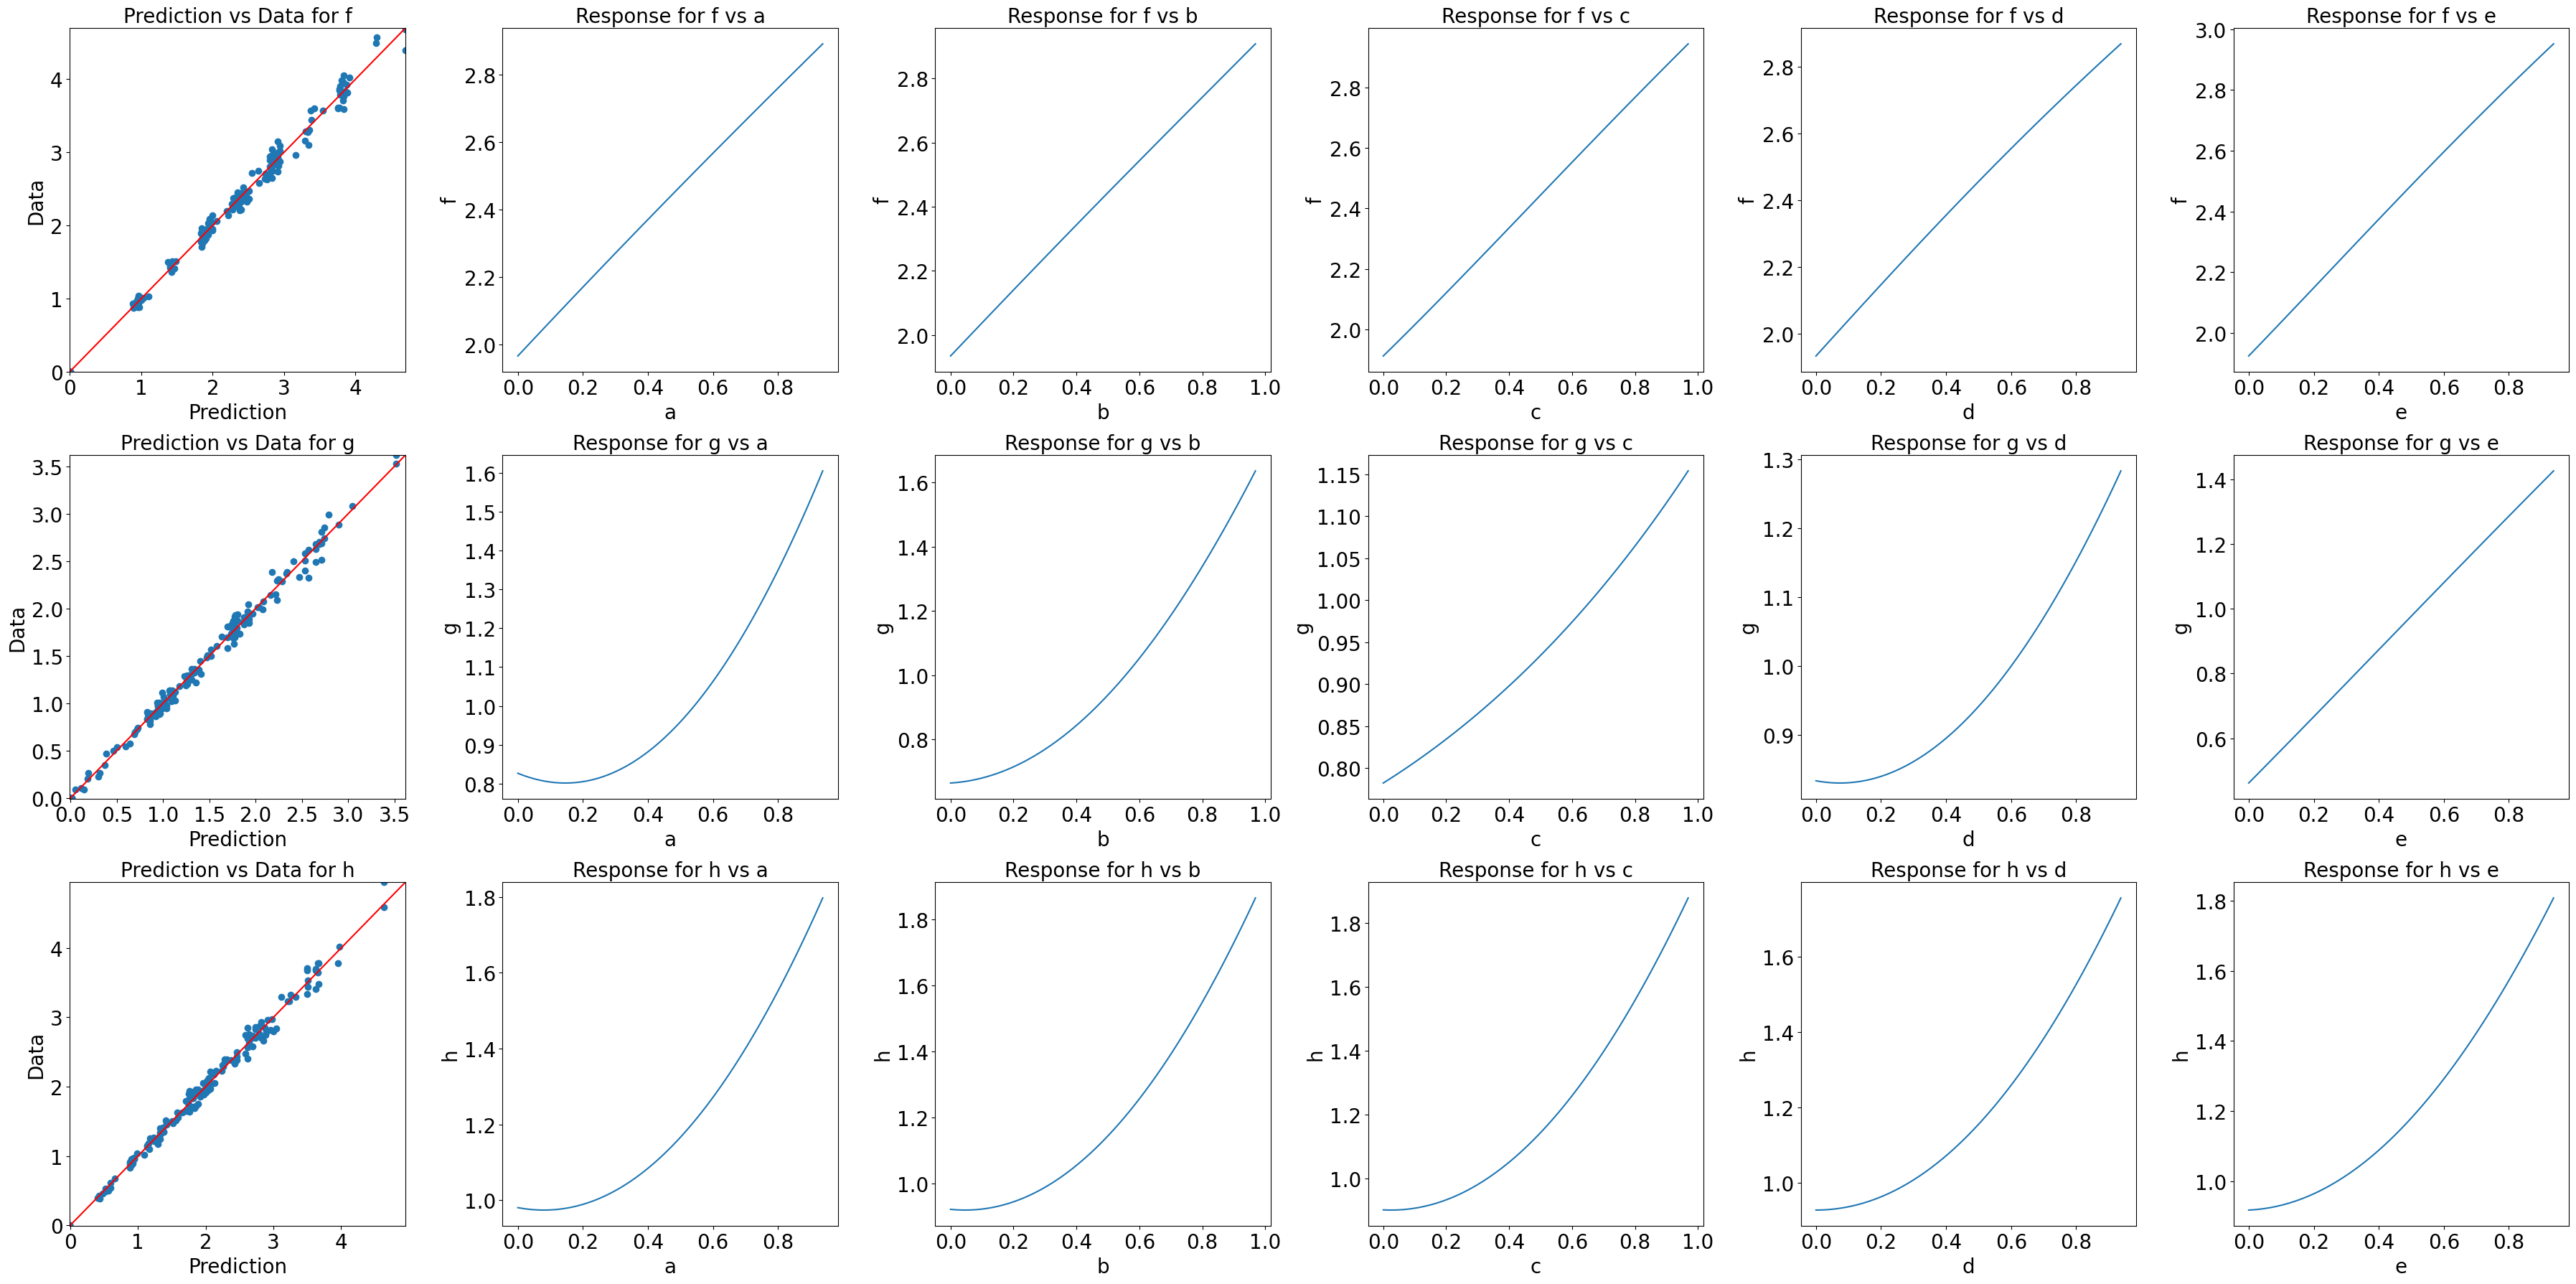

In [14]:
params = RegressorPlotParameters(gpr_regressor, start, lower_bound, upper_bound)

reg_plot = RegressorPlot(params)
reg_plot.plot()

In [15]:
gpr_regressor.error_metrics()

score                                 0.991217
r2_score                              0.991217
mean_squared_error                    0.007063
mse                                   0.007063
root_mean_squared_error               0.084043
rmse                                  0.084043
normalized_mean_squared_error         0.000357
nmse                                  0.000357
normalized_root_mean_squared_error    0.018904
nrmse                                 0.018904
dtype: float64

Now lets look at the Bayesian Polynomial Regression model again with the new data  (1st order)

In [16]:
gpr_regression_parameters = BayesianRegressionParameters(
                                                input_data=gpr_regressor.parameters.input_data,
                                                output_data=gpr_regressor.parameters.output_data, 
                                                order=1)
gpr_regressor = BayesianRegressor(gpr_regression_parameters)
gpr_regressor.fit()

Score 0.9298


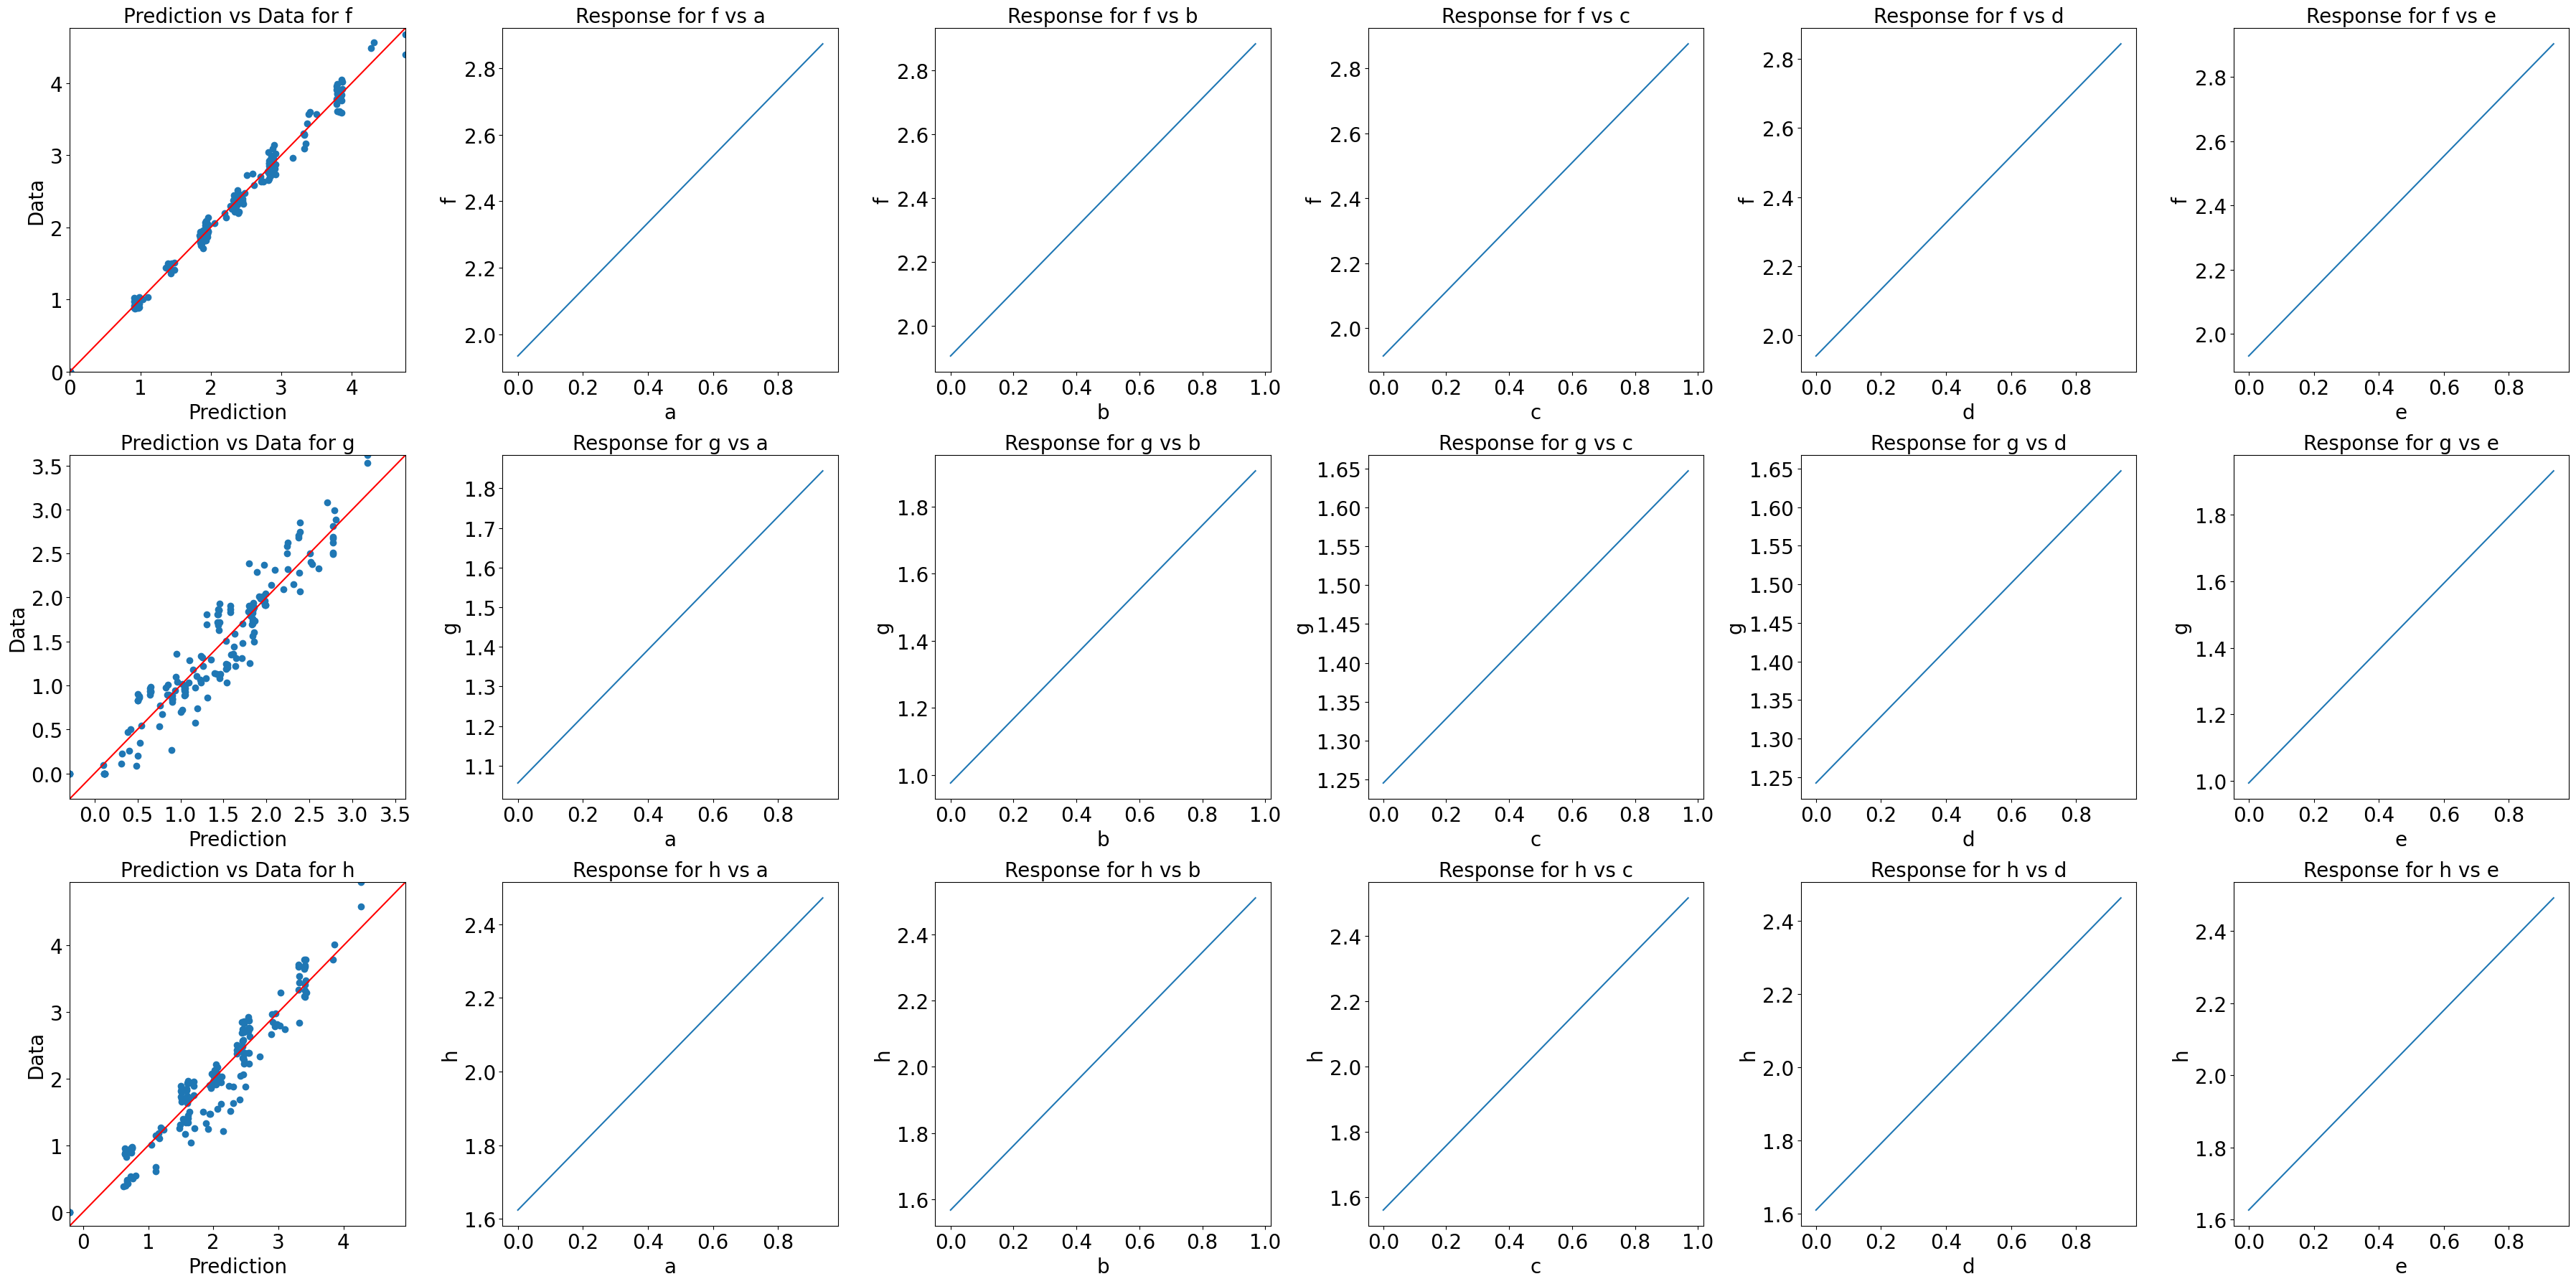

In [17]:
print(f"Score {gpr_regressor.error_metrics()['score']:.4f}")

params = RegressorPlotParameters(gpr_regressor, start, lower_bound, upper_bound)
params = RegressorPlotParameters(gpr_regressor, start, lower_bound, upper_bound)
reg_plot = RegressorPlot(params)
reg_plot.plot()

2nd order

In [18]:
gpr_regression_parameters = BayesianRegressionParameters(
                                                input_data=gpr_regressor.parameters.input_data,
                                                output_data=gpr_regressor.parameters.output_data, 
                                                order=2)
gpr_regressor = BayesianRegressor(gpr_regression_parameters)
gpr_regressor.fit()

Score 0.9895


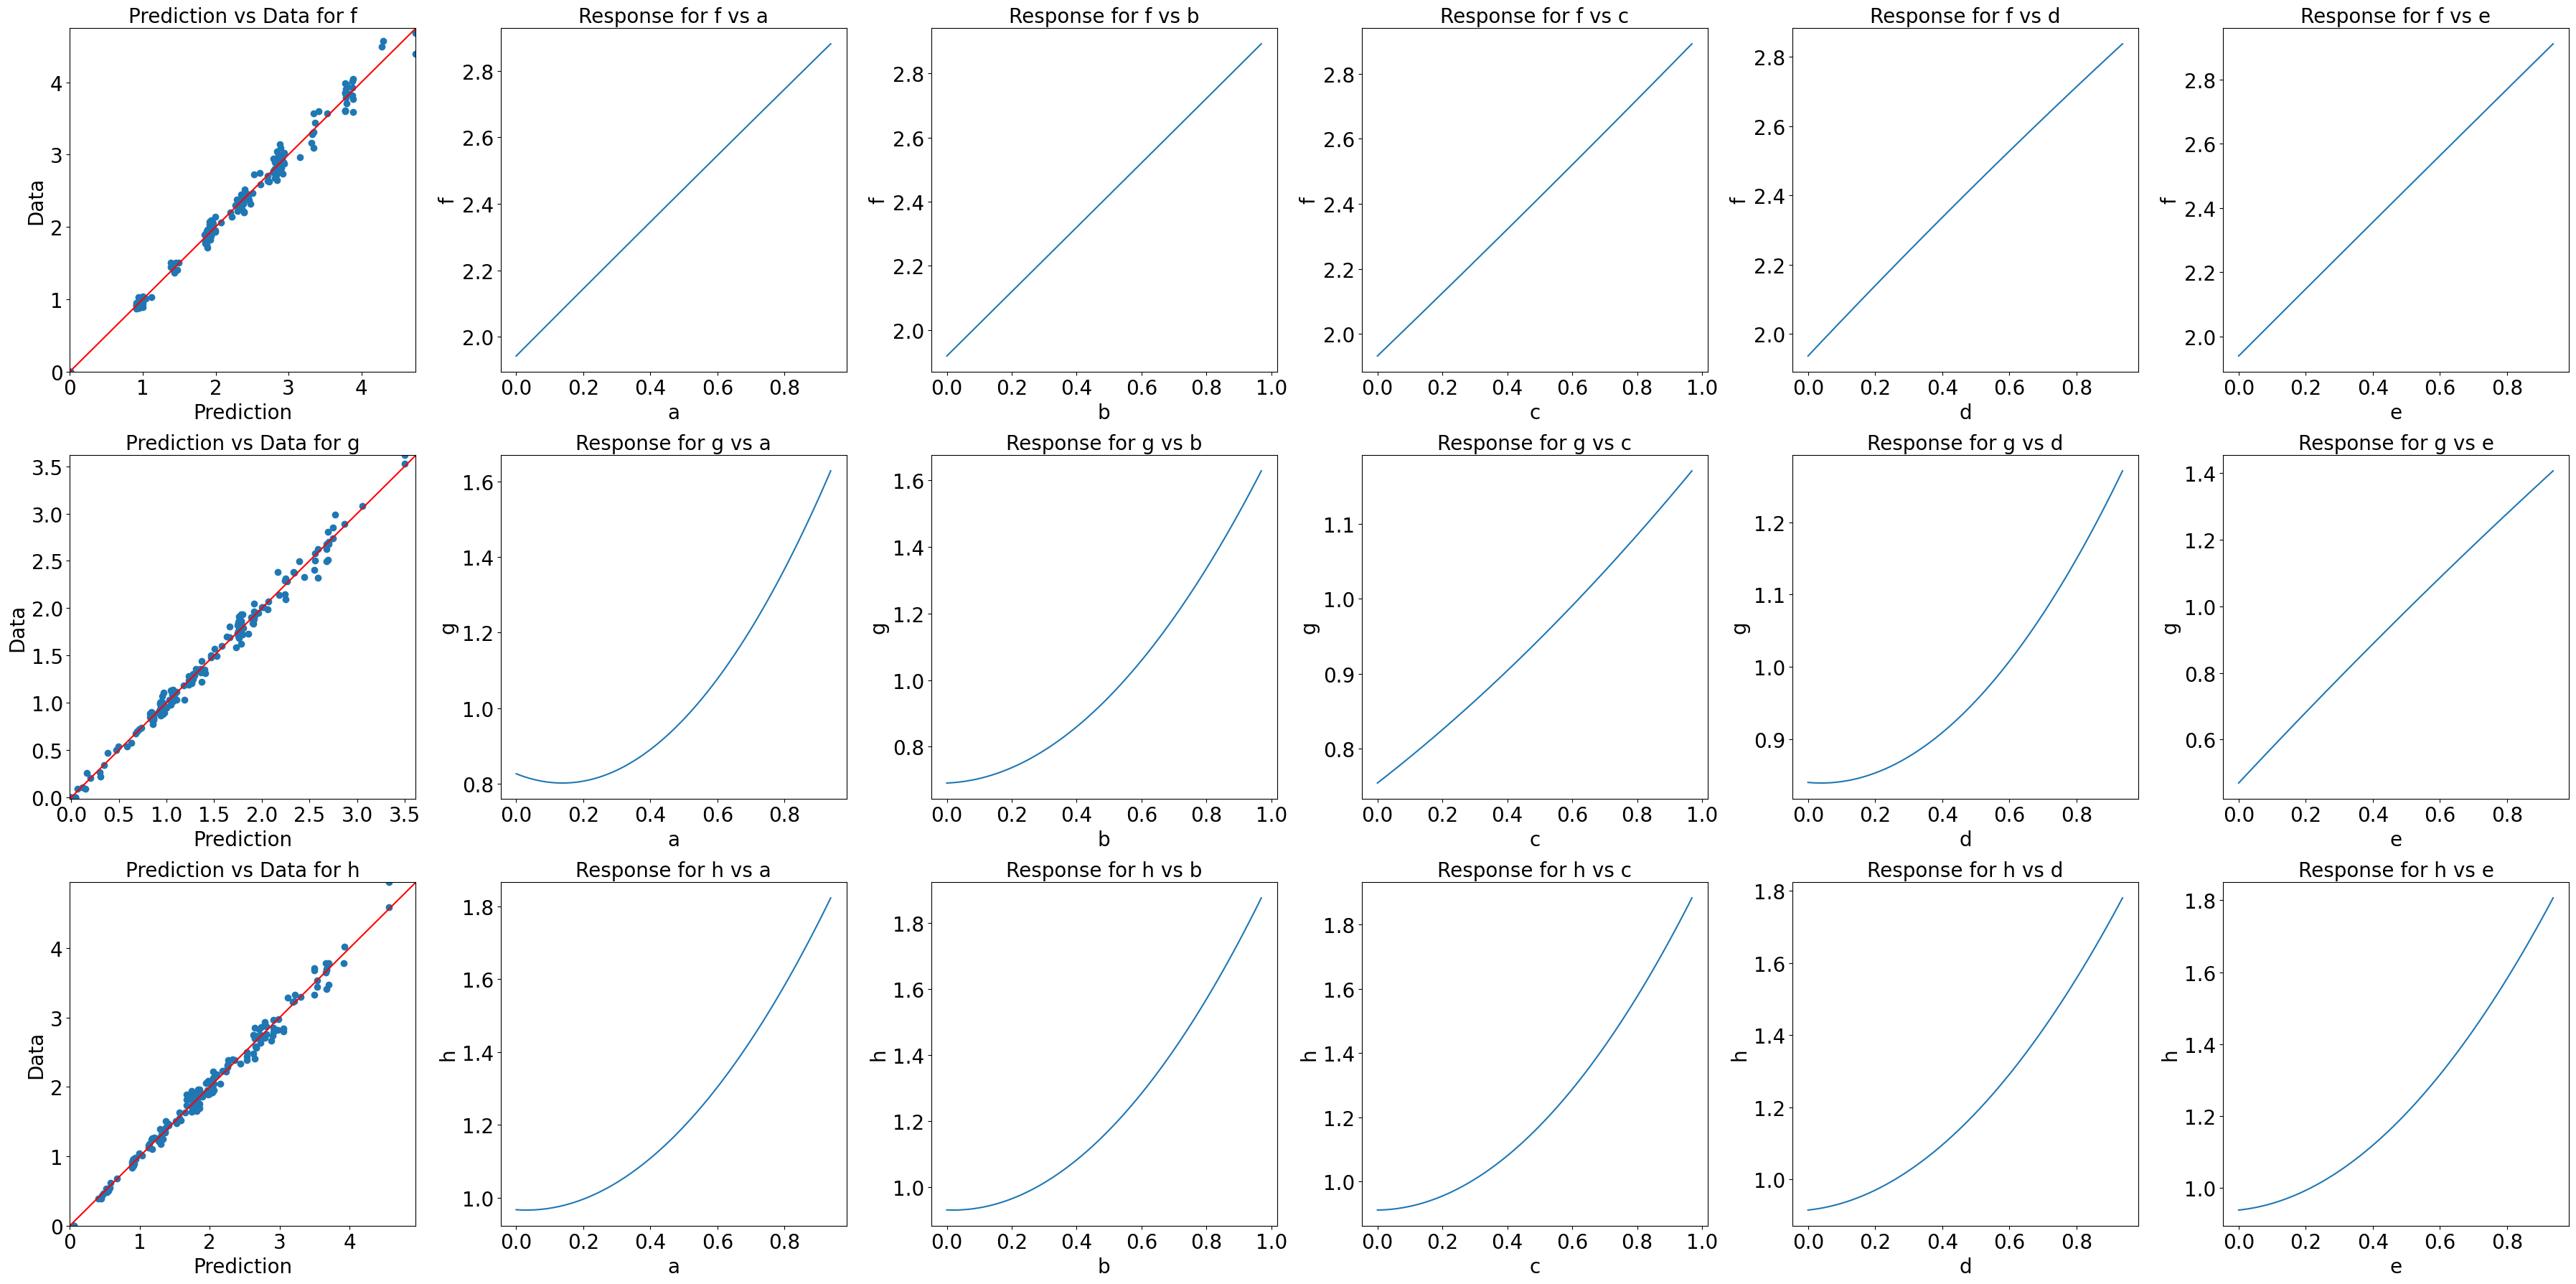

In [19]:
print(f"Score {gpr_regressor.error_metrics()['score']:.4f}")

params = RegressorPlotParameters(gpr_regressor, start, lower_bound, upper_bound)
params = RegressorPlotParameters(gpr_regressor, start, lower_bound, upper_bound)
reg_plot = RegressorPlot(params)
reg_plot.plot()

3rd order

In [20]:
gpr_regression_parameters = BayesianRegressionParameters(
                                                input_data=gpr_regressor.parameters.input_data,
                                                output_data=gpr_regressor.parameters.output_data, 
                                                order=3)
gpr_regressor = BayesianRegressor(gpr_regression_parameters)
gpr_regressor.fit()

Score 0.9913


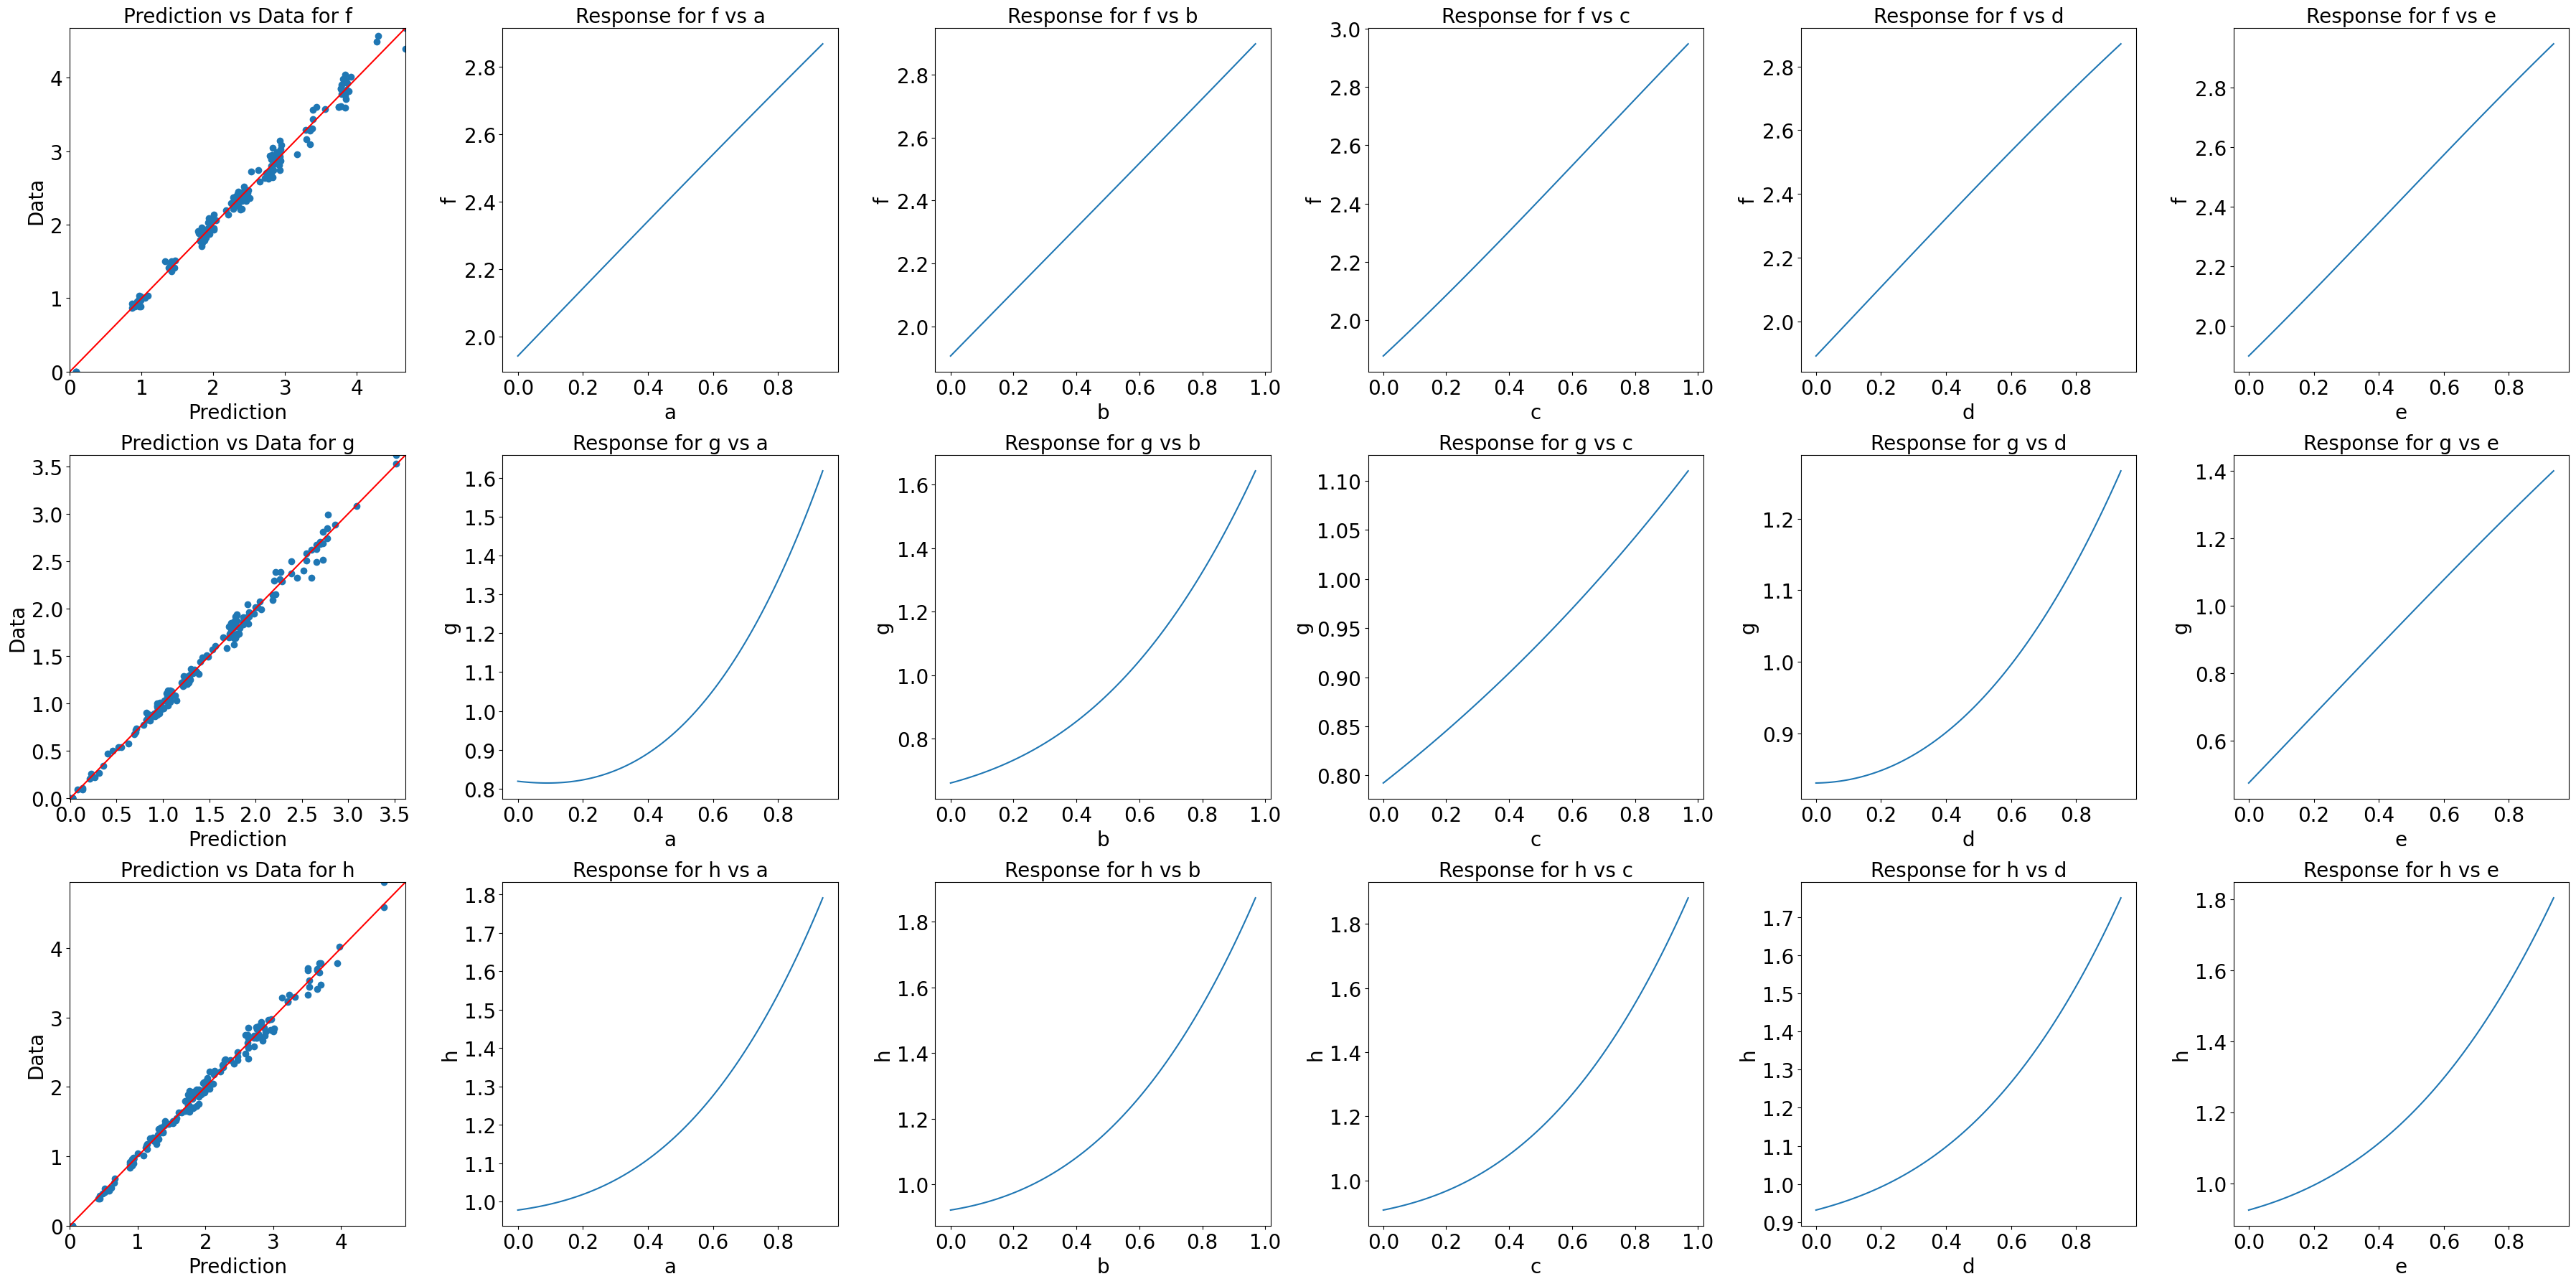

In [21]:
print(f"Score {gpr_regressor.error_metrics()['score']:.4f}")

params = RegressorPlotParameters(gpr_regressor, start, lower_bound, upper_bound)
params = RegressorPlotParameters(gpr_regressor, start, lower_bound, upper_bound)
reg_plot = RegressorPlot(params)
reg_plot.plot()

Just out of curiosity lets look at the 4th order model

In [22]:
gpr_regression_parameters = BayesianRegressionParameters(
                                                input_data=gpr_regressor.parameters.input_data,
                                                output_data=gpr_regressor.parameters.output_data, 
                                                order=4)
gpr_regressor = BayesianRegressor(gpr_regression_parameters)
gpr_regressor.fit()

Score 0.9922


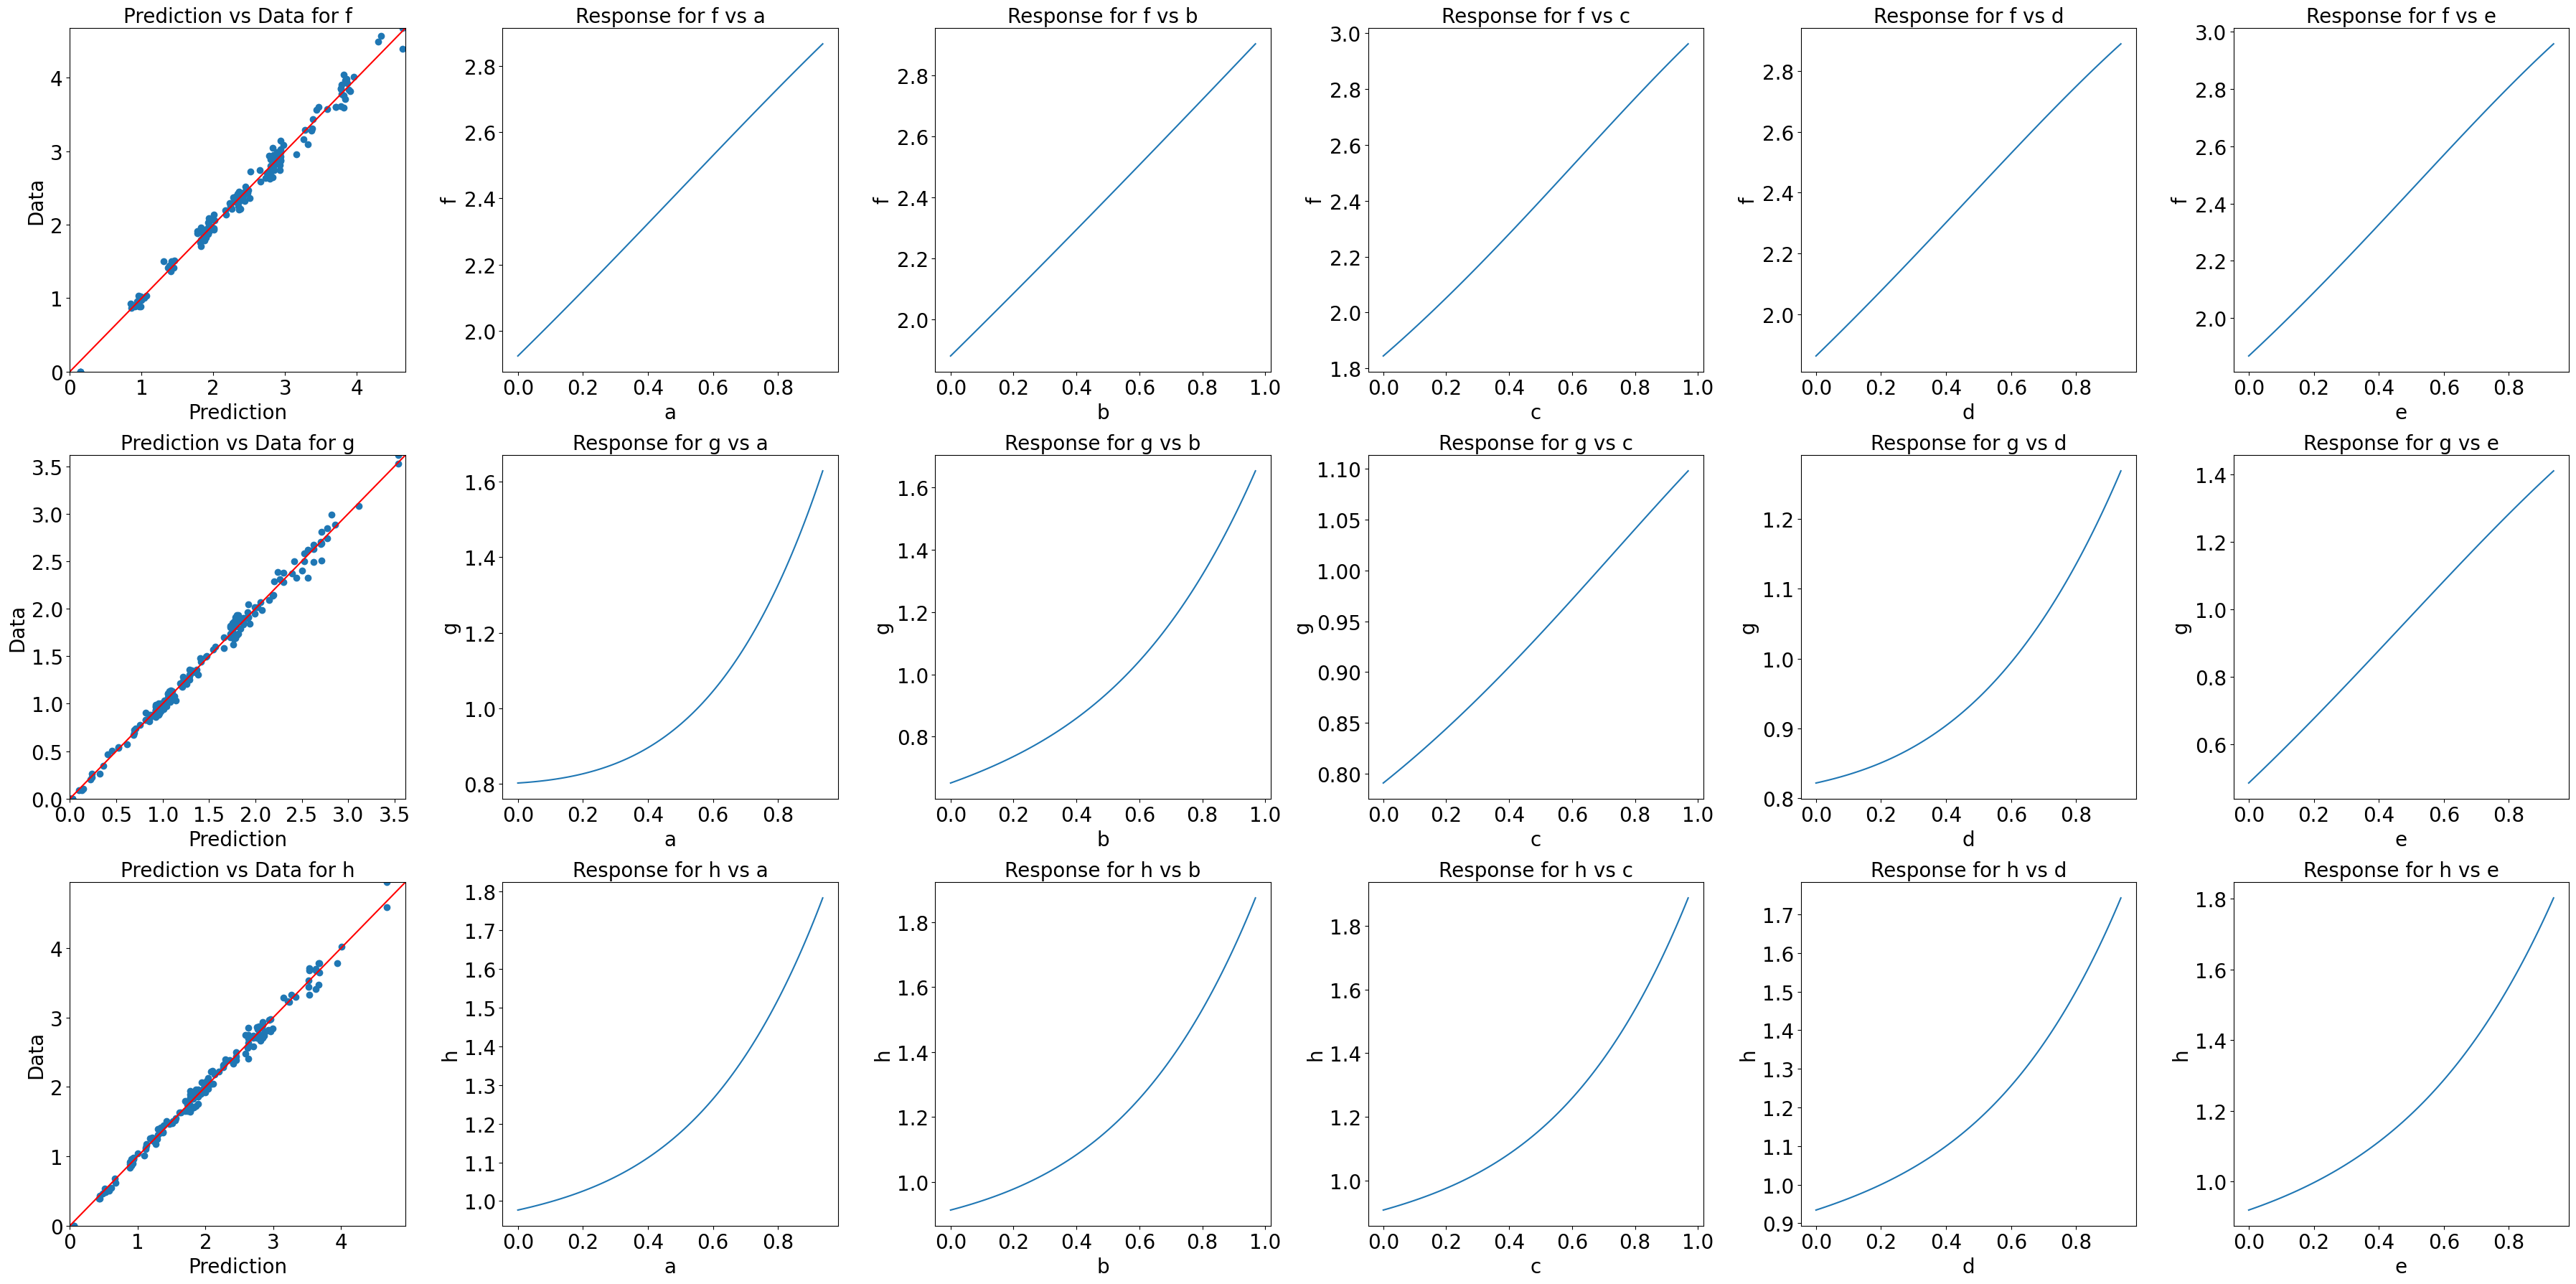

In [23]:
print(f"Score {gpr_regressor.error_metrics()['score']:.4f}")

params = RegressorPlotParameters(gpr_regressor, start, lower_bound, upper_bound)
params = RegressorPlotParameters(gpr_regressor, start, lower_bound, upper_bound)
reg_plot = RegressorPlot(params)
reg_plot.plot()